In [1]:
%matplotlib inline

import subprocess

import numpy as np
import matplotlib.pyplot as plt
import spiceypy as sp
from scipy.spatial.transform import Rotation

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
kernels = [
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/lsk/NAIF0012.TLS',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/fk/MEX_V16.TF',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/sclk/MEX_230530_STEP.TSC',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/ck/ATNM_T6_P170331235152_01813.BC',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/spk/MAR097_030101_300101_V0001.BSP',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/spk/ORMM_T19_230601000000_01813.BSP',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/ik/MEX_VMC_V04.TI',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/pck/MARS_IAU2000_V0.TPC',
    'http://spiftp.esac.esa.int/data/SPICE/MARS-EXPRESS/kernels/pck/PCK00010.TPC',
]

In [3]:
# Download kernels
for url in kernels:
    subprocess.run(['curl', '-s', url, '--output', url.split('/')[-1]]).check_returncode()

In [4]:
for url in kernels:
    sp.furnsh(url.split('/')[-1])

In [5]:
# assume that mars is a sphere for calculating its angular size
mars_radius = sp.bodvrd('MARS', 'RADII', 3)[1][0]

In [6]:
begin = np.datetime64('2023-06-02T15:48:14')  # first image seen in livestream
end = np.datetime64('2023-06-02T16:42:02')  # last image seen in livestream
t_axis = begin + np.arange((end - begin) / np.timedelta64(1, 's') + 1) * np.timedelta64(1, 's')

In [7]:
cam_angles = np.empty((t_axis.size, 2))
mars_dist = np.empty(t_axis.size)
earth_hga_angle = np.empty(t_axis.size)

for j, utc_time in enumerate(t_axis):
    et = sp.utc2et(str(utc_time))
    # VMC
    mars_x, mars_lt = sp.spkpos('mars', et, 'J2000', 'LT+S', 'MEX')
    j2000_to_vmc = sp.pxform('J2000', 'MEX_VMC', et)
    mars_vmc = sp.mxv(j2000_to_vmc, mars_x)
    cam_angles[j] = (np.arctan2(mars_vmc[0], mars_vmc[2]), np.arctan2(mars_vmc[1], mars_vmc[2]))
    mars_dist[j] = sp.vnorm(mars_x)
    # HGA
    earth_x, earth_lt = sp.spkpos('earth', et, 'J2000', 'XLT+S', 'MEX')
    j2000_to_hga = sp.pxform('J2000', 'MEX_HGA', et)
    earth_hga = sp.mxv(j2000_to_hga, earth_x)
    earth_hga_angle[j] = np.arccos(earth_hga[2] / sp.vnorm(earth_hga))
        
mars_angradius = np.arcsin(mars_radius / mars_dist)

In [8]:
vmc_fov = sp.getfvn('MEX_VMC', 4)
vmc_fov_angles = np.vstack((np.arctan2(vmc_fov[-1][:, 0], vmc_fov[-1][:, 2]),
                            np.arctan2(vmc_fov[-1][:, 1], vmc_fov[-1][:, 2]))).T

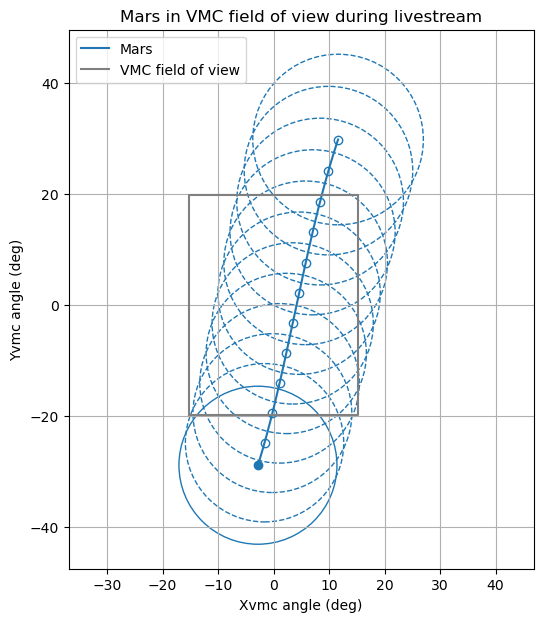

In [9]:
plt.figure(figsize=(6, 7))
plt.plot(np.rad2deg(cam_angles[:, 0]), np.rad2deg(cam_angles[:, 1]),
         label='Mars', color='C0')

skip = 300
for j in np.arange(t_axis.size)[::skip]:
    mars_circle = plt.Circle(np.rad2deg(cam_angles[j]), np.rad2deg(mars_angradius[j]),
                             color='C0', fill=False, linestyle='--')
    plt.plot(np.rad2deg(cam_angles[j, 0]), np.rad2deg(cam_angles[j, 1]), 'o', color='C0',
             fillstyle='none')
    plt.gca().add_patch(mars_circle)

mars_circle = plt.Circle(np.rad2deg(cam_angles[-1]), np.rad2deg(mars_angradius[-1]),
                         color='C0', fill=False)
plt.plot(np.rad2deg(cam_angles[-1, 0]), np.rad2deg(cam_angles[-1, 1]), 'o', color='C0')
plt.gca().add_patch(mars_circle)

plt.plot(np.rad2deg(np.concatenate((vmc_fov_angles[:, 0], vmc_fov_angles[:1, 0]))),
         np.rad2deg(np.concatenate((vmc_fov_angles[:, 1], vmc_fov_angles[:1, 1]))),
         color='grey', label='VMC field of view')

plt.axis('equal')
plt.legend()
plt.grid()
plt.xlabel('Xvmc angle (deg)')
plt.ylabel('Yvmc angle (deg)')
plt.title('Mars in VMC field of view during livestream');

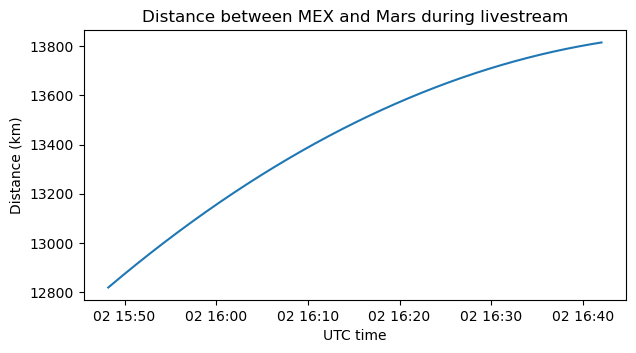

In [10]:
plt.plot(t_axis, mars_dist)
plt.title('Distance between MEX and Mars during livestream')
plt.xlabel('UTC time')
plt.ylabel('Distance (km)');

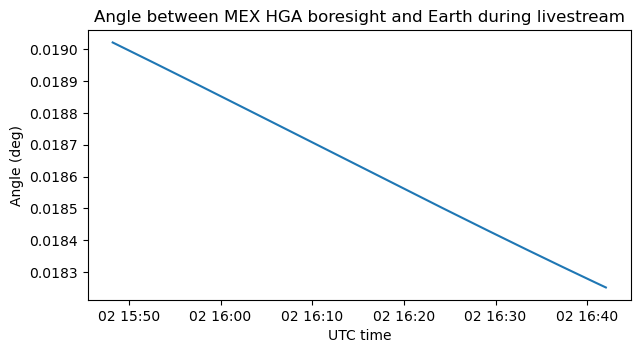

In [11]:
plt.plot(t_axis, np.rad2deg(earth_hga_angle))
plt.title('Angle between MEX HGA boresight and Earth during livestream')
plt.xlabel('UTC time')
plt.ylabel('Angle (deg)');

In [12]:
vmc_to_hga = sp.pxform('MEX_VMC', 'MEX_HGA', sp.utc2et(str(begin)))
vmc_boresight_in_hga = sp.mxv(vmc_to_hga, [0, 0, 1])
vmc_hga_sep = sp.vsep(vmc_boresight_in_hga, [0, 0, 1])
np.rad2deg(vmc_hga_sep)

85.36985693082346

In [13]:
t_orbits = np.datetime64('2023-06-02T00:00:00') + np.arange(0, 24 * 3600, 10) * np.timedelta64(1, 's')

mars_earth_angle = np.empty(t_orbits.size)
mex_mars_state = np.empty((t_orbits.size, 6))
mex_rot = np.empty((t_orbits.size, 3, 3))
sun_angle_y = np.empty(t_orbits.size)
earth_hga_angle = np.empty(t_orbits.size)
eclipse = np.empty(t_orbits.size, 'int')

for j, utc_time in enumerate(t_orbits):
    et = sp.utc2et(str(utc_time))
    mars_x, mars_lt = sp.spkpos('mars', et, 'J2000', 'LT+S', 'MEX')
    earth_x, earth_lt = sp.spkpos('earth', et, 'J2000', 'XLT+S', 'MEX')
    mars_earth_angle[j] = sp.vsep(mars_x, earth_x)
    mex_mars_state[j] = sp.spkezr('MEX', et, 'J2000', 'none', 'mars')[0]
    mex_rot[j] = sp.pxform('MEX_SPACECRAFT', 'J2000', et)
    sun_x, sun_lt = sp.spkpos('sun', et, 'J2000', 'LT+S', 'MEX')
    j2000_to_spacecraft = sp.pxform('J2000', 'MEX_SPACECRAFT', et)
    sun_spacecraft = sp.mxv(j2000_to_spacecraft, sun_x)
    sun_angle_y[j] = np.arcsin(sun_spacecraft[1] / sp.vnorm(sun_spacecraft))
    j2000_to_hga = sp.pxform('J2000', 'MEX_HGA', et)
    earth_hga = sp.mxv(j2000_to_hga, earth_x)
    earth_hga_angle[j] = np.arccos(earth_hga[2] / sp.vnorm(earth_hga))
    eclipse[j] = sp.occult('MARS', 'ELLIPSOID', 'IAU_MARS', 'SUN', 'ELLIPSOID', 'IAU_SUN', 'CN', 'MEX', et)
    
    spacecraft_to_j2000 = sp.pxform('MEX_HGA', 'J2000', et)

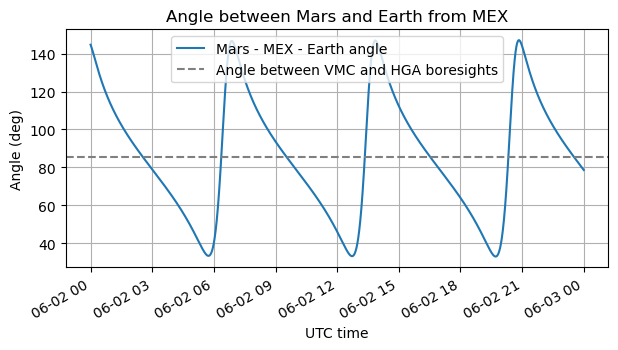

In [14]:
plt.plot(t_orbits, np.rad2deg(mars_earth_angle), label='Mars - MEX - Earth angle')
plt.axhline(y=np.rad2deg(vmc_hga_sep), linestyle='--', color='gray',
            label='Angle between VMC and HGA boresights')
plt.grid()
plt.gcf().autofmt_xdate()
plt.title('Angle between Mars and Earth from MEX')
plt.xlabel('UTC time')
plt.ylabel('Angle (deg)')
plt.legend();

In [15]:
orbit_normal = np.cross(mex_mars_state[0, :3], mex_mars_state[0, -3:])
orbit_normal /= sp.vnorm(orbit_normal)
j2000_axis_proj = [0, 0, 1] - orbit_normal[2] * orbit_normal
j2000_axis_proj /= sp.vnorm(j2000_axis_proj)
xaxis = np.cross(j2000_axis_proj, orbit_normal)
rotm = np.vstack((xaxis, j2000_axis_proj, orbit_normal))
mex_pos_rot = rotm @ mex_mars_state[:, :3].T

In [16]:
np.rad2deg(sp.vsep(earth_x, orbit_normal) - np.pi/2)

32.87028350898326

In [17]:
np.rad2deg(sp.vsep(sun_x, orbit_normal) - np.pi/2)

2.8088274297648903

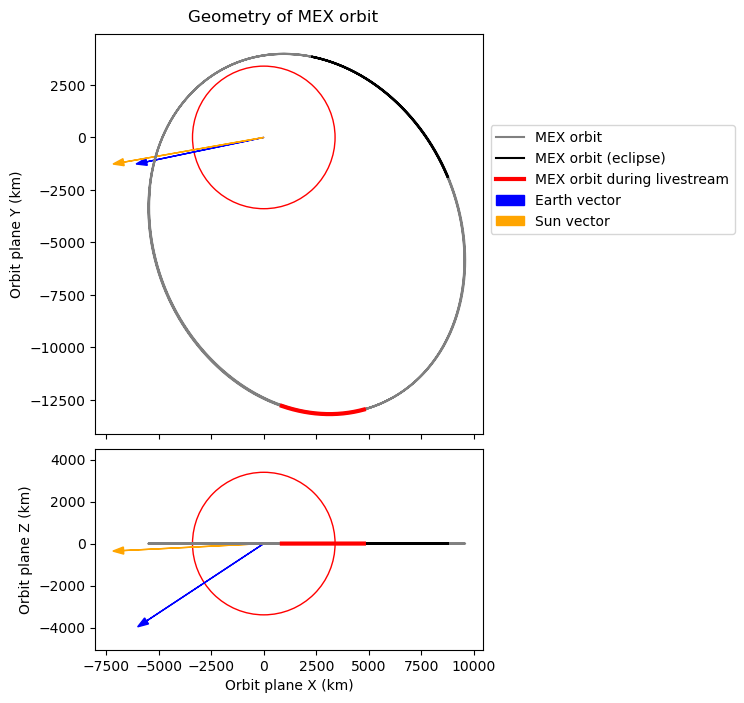

In [18]:
fig,axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True, height_ratios=[2, 1])

axs[0].plot(mex_pos_rot[0], mex_pos_rot[1], color='grey', label='MEX orbit')
axs[1].plot(mex_pos_rot[0], mex_pos_rot[2], color='grey')

mex_pos_eclipse = np.copy(mex_pos_rot)
mex_pos_eclipse[:, eclipse == 0] = np.nan
axs[0].plot(mex_pos_eclipse[0], mex_pos_eclipse[1], color='black', label='MEX orbit (eclipse)')
axs[1].plot(mex_pos_eclipse[0], mex_pos_eclipse[2], color='black')

tsel = (t_orbits >= begin) & (t_orbits <= end)
axs[0].plot(mex_pos_rot[0, tsel], mex_pos_rot[1, tsel], color='red', linewidth=3,
            label='MEX orbit during livestream')
axs[1].plot(mex_pos_rot[0, tsel], mex_pos_rot[2, tsel], color='red', linewidth=3)
for ax in axs:
    ax.add_patch(plt.Circle((0, 0), mars_radius, fill=False, color='red'))
earth_vec = rotm @ earth_x
earth_vec = 2.0 * mars_radius * earth_vec / sp.vnorm(earth_vec)
axs[0].arrow(0, 0, earth_vec[0], earth_vec[1], color='blue', head_width=mars_radius*0.1,
             label='Earth vector')
axs[1].arrow(0, 0, earth_vec[0], earth_vec[2], color='blue', head_width=mars_radius*0.1)

sun_vec = rotm @ sun_x
sun_vec = 2.0 * mars_radius * sun_vec / sp.vnorm(sun_vec)
axs[0].arrow(0, 0, sun_vec[0], sun_vec[1], color='orange', head_width=mars_radius*0.1,
             label='Sun vector')
axs[1].arrow(0, 0, sun_vec[0], sun_vec[2], color='orange', head_width=mars_radius*0.1)

axs[0].legend(loc=[1.02, 0.5])
for ax in axs:
    ax.axis('equal')
plt.subplots_adjust(hspace=0.05)
plt.suptitle('Geometry of MEX orbit', y=0.91)
axs[0].set_ylabel('Orbit plane Y (km)')
axs[1].set_ylabel('Orbit plane Z (km)')
axs[1].set_xlabel('Orbit plane X (km)');

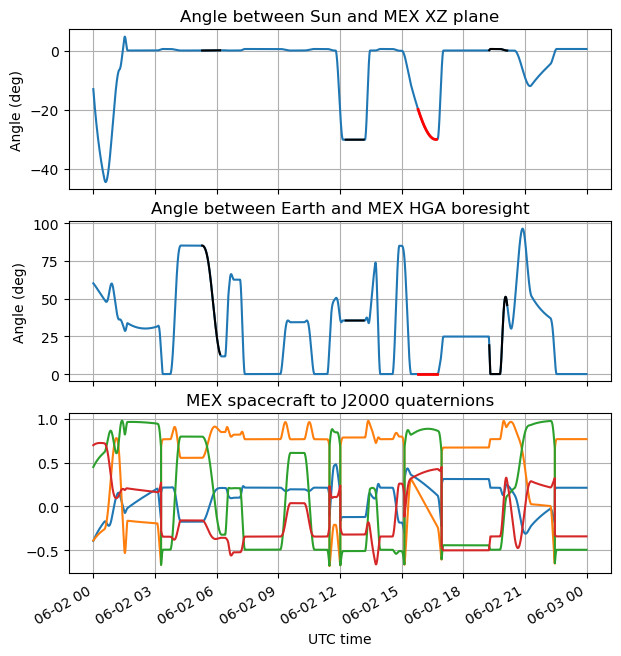

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
axs[0].plot(t_orbits, np.rad2deg(sun_angle_y))
axs[0].plot(t_orbits[tsel], np.rad2deg(sun_angle_y[tsel]), color='red', linewidth=2)

angle_eclipse = np.rad2deg(sun_angle_y)
angle_eclipse[eclipse == 0] = np.nan
axs[0].plot(t_orbits, angle_eclipse, 'black')

axs[1].plot(t_orbits, np.rad2deg(earth_hga_angle))
axs[1].plot(t_orbits[tsel], np.rad2deg(earth_hga_angle[tsel]), color='red', linewidth=2)

angle_eclipse = np.rad2deg(earth_hga_angle)
angle_eclipse[eclipse == 0] = np.nan
axs[1].plot(t_orbits, angle_eclipse, 'black')

axs[2].plot(t_orbits, Rotation.from_matrix(mex_rot).as_quat())

fig.autofmt_xdate()

for ax in axs:
    ax.grid()
    
axs[-1].set_xlabel('UTC time')
axs[0].set_title('Angle between Sun and MEX XZ plane')
axs[1].set_title('Angle between Earth and MEX HGA boresight')
axs[2].set_title('MEX spacecraft to J2000 quaternions')
for ax in axs[:2]:
    ax.set_ylabel('Angle (deg)')